In [29]:
import joblib
import pandas
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import  xgboost as xgb
import os
import gc
import catboost as ctb
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold




class PREPROCESS:
    categorical = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
    catboost_prep = True
    xgb_lgb_prep = False




class CONFIG:
    def __init__(self, name: str, params: dict, num_boost_round: int, early_stopping = None, verbose_eval = None, n_folds = None):
        self.name = name
        self.params = params
        self.num_boost_round = num_boost_round
        self.early_stopping = early_stopping
        self.verbose_eval = verbose_eval
        self.n_folds = n_folds
    def __str__(self):
        s = self.name; s += '\n'
        s += 'Booster parameters:\n'
        for k, v in self.params.items():
            s += f'{k}: {v}\n'
        s += '.train() args:\n'
        s += f'Number of boosting rounds: {self.num_boost_round}\n'
        if self.early_stopping is not None:
            s += f'Early stopping rounds: {self.early_stopping}\n'
        if self.verbose_eval is not None:
            s += f'Verbose eval: {self.verbose_eval}\n'
        if self.n_folds is  not None:
            s += f'Stratified K-Fold number of splits: {self.n_folds}\n'
        s += 'END OF CONFIG'
        return s
    def save(self, path: str):
        f = open(path, 'w')
        print(self.__str__(), file=f)
        f.close()




def one_hot(train, test):
    """
    Simple encoding using pandas.DataFrame.get_dummies()

    !!! If some values do not appear in both datasets in same column
    function will not work correctly. Check that test and train have same columns !!!

    :param train: train dataset <- pandas.DataFrame
    :param test: test dataset <- pandas.DataFrame
    :return: same datasets with one hot encoded categoricals -> tuple[pandas.DataFrame, pandas.DataFrame]
    """
    c_enc = train.columns.to_series().groupby(train.dtypes).groups[np.dtype('object')].tolist()
    for col in c_enc:
        dummies = pd.get_dummies(train[col], prefix=col, drop_first=False)
        train = pd.concat([train, dummies], axis=1)
        train.drop(columns=col, inplace=True)
        dummies = pd.get_dummies(test[col], prefix=col, drop_first=False)
        test = pd.concat([test, dummies], axis=1)
        test.drop(columns=col, inplace=True)
    gc.collect()
    return train, test

def amex_metric(y_true, y_pred):
    """
    Amex Kaggle Competition Metric
    :param y_true: true labels
    :param y_pred: predicted values
    :return: metric score -> float
    """
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:,0]==0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])
    gini = [0,0]
    for i in [1,0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:,0]==0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] *  weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)
    return 0.5 * (gini[1]/gini[0] + top_four)
def lgb_amex_metric(preds: np.ndarray, train_data: lgb.Dataset):
    y_true = train_data.get_label()
    eval_name = 'amex_metric'
    value = amex_metric(y_true, preds)
    is_higher_better = True
    return eval_name, value, is_higher_better
def xgb_amex_metric(predt: np.ndarray, dtrain: xgb.DMatrix):
    """
    Custom Metric for XGBoost
    using Amex Metric
    :param predt: predicted values <- np.ndarray
    :param dtrain: matrix to get labels (true values) from <- xgb.Dmatrix
    :return: name of the metric, score -> tuple[str, float]
    """
    y_true = dtrain.get_label()
    return 'amex_metric', amex_metric(y_true, predt)
def file_mem_usage_gb(file_name: str):
    """
    Disk memory usage of file in GB
    :param file_name: pathlike[str]
    :return: size in GB -> float
    """
    return round((os.stat(file_name).st_size/1073741824), 2)
def mem_usage_gb(df: pandas.DataFrame, deep: bool):
    """
    Memory usage of DataFrame
    :param df: dataset <- pandas.DataFrame
    :param deep: parameter of pandas.DataFrame.memory_usage(deep=) <- bool
    :return: rounded memory usage in GB -> float
    """
    return round((df.memory_usage(deep=deep).sum()/1073741824), 2)

In [30]:
config_xgb = CONFIG('CONFIG_XGB',
                    params= {
                        'eta': 0.04,
                        'gamma': 0,
                        'max_depth': 6,
                        'min_child_weight': 1,
                        'max_delta_step': 1, #suggested by xgb documentation for imbalanced dataset
                        'max_leaves': 127,
                        'objective': 'binary:logistic',
                        'scale_pos_weight': 3, #suggested by lgb documentation for imbalanced dataset
                        'disable_default_eval_metric': 1,
                        # cant use gpu on laptop better use gpu_hist
                        'tree_method': 'hist'},
                    num_boost_round= 1500,
                    early_stopping= 1200,
                    verbose_eval= 250,
                    n_folds= 5
                    )
config_lgb = CONFIG('CONFIG_LGBM',
                    params= {
                        'boosting_type': 'dart',
                        'objective': 'binary',
                        'max_delta_step': 1, #suggested by xgb documentation for imbalanced dataset
                        'scale_pos_weight': 2.86, #suggested by lgb documentation for imbalanced dataset
                        # num negative class / num pos class
                        'learning_rate': 0.04,
                        # 'device_type': 'gpu'
                        'num_leaves': 127},
                    num_boost_round= 1200,
                    early_stopping= 900,
                    verbose_eval= 200,
                    n_folds= 5
                    )

In [31]:
def read_datasets(train_path: str, test_path: str, labels_path: str, plot_labels = True):
    # load train, test
    train = pd.read_parquet(train_path)
    test = pd.read_parquet(test_path)
    # print memory usage
    print('train dataset mem usage:', mem_usage_gb(df=train, deep=True), 'GB')
    print('test dataset mem usage:', mem_usage_gb(df=test, deep=True), 'GB')
    # load true labels for train (target)
    labels = pd.read_csv(labels_path)
    labels.drop(columns= ['customer_ID'], inplace= True)
    # convert labels to numpy.array
    labels = np.ravel(labels)
    # get unique labels counts to see whether the dataset is imbalanced
    # Creating plot
    if plot_labels:
        counts, names = get_label_counts(labels)
        plt.pie(counts, labels = names)
        plt.title('Counts of unique labels')
        # show plot
        plt.show()
    # return datasets
    return train, test, labels




def agg_and_save_dataset(train: pd.DataFrame, test: pd.DataFrame):
    # get numerical features
    numerical = train.drop(columns= PREPROCESS.categorical).columns.to_list()
    numerical.remove('customer_ID'); numerical.remove('S_2')

    # preprocess train
    # aggregate numerical columns for each customer by mean, std, min, max, last entry
    # rows reduced from 5,5 mil to 458k
    train_num_agg = train.groupby("customer_ID")[numerical].agg(['mean', 'std', 'min', 'max', 'last'])
    train_num_agg.columns = ['_'.join(x) for x in train_num_agg.columns]
    train_num_agg.reset_index(inplace = True)
    train_num_agg.drop(['customer_ID'], axis= 1, inplace= True)
    # aggregate categoricals by count, last, number of unique entries
    train_cat_agg = train.groupby("customer_ID")[PREPROCESS.categorical].agg(['count', 'last', 'nunique'])
    train_cat_agg.columns = ['_'.join(x) for x in train_cat_agg.columns]
    train_cat_agg.reset_index(inplace = True)
    train_cat_agg.drop(['customer_ID'], axis= 1, inplace= True)
    agg_cat_cols = train_cat_agg.columns.tolist()
    train = pd.concat([train_num_agg, train_cat_agg], axis= 1)
    del train_num_agg, train_cat_agg
    train.to_parquet('train_agg.parquet')
    print('train aggregated')
    del train
    gc.collect()

    # preprocess test
    # essentially the same
    # aggregate numerical columns for each customer by mean, std, min, max, last entry
    test_num_agg = test.groupby("customer_ID")[numerical].agg(['mean', 'std', 'min', 'max', 'last'])
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]
    test_num_agg.reset_index(inplace = True)
    test_num_agg.drop(['customer_ID'], axis= 1, inplace= True)
    # aggregate categoricals by count, last, number of unique entries
    test_cat_agg = test.groupby("customer_ID")[PREPROCESS.categorical].agg(['count', 'last', 'nunique'])
    test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]
    test_cat_agg.reset_index(inplace = True)
    test_cat_agg.drop(['customer_ID'], axis= 1, inplace= True)
    test = pd.concat([test_num_agg, test_cat_agg], axis= 1)
    del test_num_agg, test_cat_agg
    test.to_parquet('test_agg.parquet')
    print('test aggregated')
    del test
    gc.collect()
    return agg_cat_cols

def encode_datasets(train: pd.DataFrame, test: pd.DataFrame, agg_cat_cols: list,  prep_flag: bool):
    # different encoding for different gradient boosting libraries
    if prep_flag:
        # prep for catboost.
        # catboost accepts categorical features in raw form as string or integers
        # no NaN's, float's can be present in categorical features
        # change dtypes float to object, fill NaN in cat. columns with some string. I chose 'no_data'
        # as I understood Catboost uses one-hot encoding automatically
        print('preprocessing for Catboost')
        nulls = train[agg_cat_cols].isna().sum(); types = train[agg_cat_cols].dtypes
        cat_stats = pd.concat([nulls, types], axis=1).rename(columns={0: "NaN_count", 1: "type"})
        cols_to_encode = cat_stats.loc[(cat_stats['NaN_count'] != 0) | (cat_stats['type'] == 'float16')].index.tolist()
        for col in cols_to_encode:
            train[col] = train[col].astype('object')
            train[col] = train[col].map(str)
        train[agg_cat_cols].fillna('no_data', inplace= True)
        nulls = test[agg_cat_cols].isna().sum(); types = test[agg_cat_cols].dtypes
        cat_stats = pd.concat([nulls, types], axis= 1).rename(columns= {0: "NaN_count", 1: "type"})
        cols_to_encode = cat_stats.loc[(cat_stats['NaN_count'] != 0) | (cat_stats['type'] == 'float16')].index.tolist()
        for col in cols_to_encode:
            test[col] = test[col].astype('object')
            test[col] = test[col].map(str)
        test[agg_cat_cols].fillna('no_data', inplace=True)
    else:
        # else I one-hot encode manually
        # unique values in categoricals of train and test differ
        # one unique value in train appears, that does not in test
        # I have to add a column of 0 manually to test for that value
        # Initially I got the missing col by getting difference of sets of columns (train - test),
        # but here the column is added manually for the sake of simplicity (I'm lazy)
        print('Preprocessing for LGB / XGB')
        train, test = one_hot(train, test)
        idx = train.columns.get_loc('D_64_last_-1')
        test.insert(loc=idx, column='D_64_last_-1', value=[0] * len(test))
        test['D_64_last_-1'] = test['D_64_last_-1'].astype('uint8')
    return train, test



def get_label_counts(labels: np.ndarray):
    unique, counts = np.unique(labels, return_counts=True)
    count_dict = dict(zip(unique, counts))
    names = []
    for k, v in count_dict.items():
        names.append(f'{k}, {round(v / len(labels), 2) * 100}%')
        print(f'Count of {k}: ({v} / {len(labels)}), percentage = {round(v / len(labels), 4) * 100}%')
    return counts, names




def train_and_predict_xgb(train_data: pd.DataFrame, test_data: pd.DataFrame, train_labels: np.ndarray, config: CONFIG):
    plots = []
    total_predictions = np.zeros(test_data.shape[0])
    oof_predictions = np.zeros(train_data.shape[0])
    print(config)
    skf = StratifiedKFold(n_splits=config.n_folds)
    n = 1
    for train_index, valid_index in skf.split(train_data, train_labels):
        results = dict()
        print('=' * 60)
        print(f'====== Fold number: {n}')
        print('=' * 60)
        # Get counts of 0 and 1 in K-Fold labels
        # to see that folds are indeed stratified (percentages of classes are preserved)
        print('label counts in train')
        get_label_counts(train_labels[train_index])
        print('label counts in test(eval)')
        get_label_counts(train_labels[valid_index])

        d_train = xgb.DMatrix(train_data.iloc[train_index], train_labels[train_index])
        d_valid = xgb.DMatrix(train_data.iloc[valid_index], train_labels[valid_index])

        model = xgb.train(config.params,
                          dtrain= d_train,
                          num_boost_round= config.num_boost_round,
                          evals= [(d_train, 'train'), (d_valid, 'valid')],
                          custom_metric= xgb_amex_metric,
                          early_stopping_rounds= config.early_stopping,
                          evals_result= results,
                          verbose_eval= config.verbose_eval,
                          )
        path = 'C:/Users/boomb/DataspellProjects/dsProject_1/models/'
        joblib.dump(model, path + f'xgb_model_fold{n}.joblib')
        #=======================
        # plot metrics
        #=======================
        epochs = len(results['valid']['amex_metric'])
        x_axis = range(0, epochs)
        fig, ax = plt.subplots()
        ax.plot(x_axis, results['train']['amex_metric'], label='Train')
        ax.plot(x_axis, results['valid']['amex_metric'], label='Valid')
        ax.legend()
        plt.ylabel('AMEX_METRIC')
        plt.title(f'XGBoost AMEX fold {n}')
        plt.show()

        # get fold predictions
        valid_predictions = model.predict(d_valid)
        oof_predictions[valid_index] = valid_predictions
        # get test predictions
        d_test = xgb.DMatrix(test_data)
        fold_test_predictions = model.predict(d_test)
        # adjust predictions according to n_folds
        total_predictions += fold_test_predictions / config.n_folds
        print('Fold model successfully trained. Predictions saved')
        print(f'fold {n} score: {amex_metric(y_true=train_labels[valid_index], y_pred=valid_predictions)}')
        n += 1
    del d_train, d_valid, d_test
    gc.collect()
    print('=' * 60)
    print(f'TOTAL out of folds score: {amex_metric(y_true=train_labels, y_pred=oof_predictions)}')
    sample = pd.read_csv('sample_submission.csv')
    output = pd.DataFrame({'customer_ID': sample.customer_ID, 'prediction': total_predictions})
    return output




def train_and_predict_lgbm(train_data: pd.DataFrame, test_data: pd.DataFrame, train_labels: np.ndarray, config: CONFIG):
    total_predictions = np.zeros(test_data.shape[0])
    oof_predictions = np.zeros(train_data.shape[0])
    print(config)
    skf = StratifiedKFold(n_splits=config.n_folds)
    n = 1
    for train_index, valid_index in skf.split(train_data, train_labels):
        results = dict()
        print('=' * 60)
        print(f'Fold number: {n}')
        print('=' * 60)
        # Get counts of 0 and 1 in K-Fold labels
        # to see that folds are indeed stratified (percentages of classes are preserved)
        print('label counts in train')
        get_label_counts(train_labels[train_index])
        print('label counts in test(eval)')
        get_label_counts(train_labels[valid_index])
        callbacks = [# lgb.early_stopping(config.early_stopping),
                     lgb.log_evaluation(config.verbose_eval),
                     lgb.record_evaluation(results)]
        d_train = lgb.Dataset(data=train_data.iloc[train_index], label=train_labels[train_index])
        d_valid = lgb.Dataset(data=train_data.iloc[valid_index], label=train_labels[valid_index])
        model = lgb.train(config.params,
                          train_set = d_train,
                          num_boost_round= config.num_boost_round,
                          valid_sets= [d_train, d_valid],
                          valid_names=['train', 'valid'],
                          feval=lgb_amex_metric,
                          callbacks=callbacks
                          )
        path = 'C:/Users/boomb/DataspellProjects/dsProject_1/models/'
        joblib.dump(model, path + f'lgb_model_fold{n}.joblib')
        #=======================
        # plot metrics
        #=======================
        lgb.plot_metric(results,
                        'amex_metric')
        plt.show()

        # get fold predictions
        valid_predictions = model.predict(train_data.iloc[valid_index])
        oof_predictions[valid_index] = valid_predictions
        # get test predictions
        fold_test_predictions = model.predict(test_data)
        # adjust predictions according to n_folds
        total_predictions += fold_test_predictions / config.n_folds
        print('Fold model successfully trained. Predictions saved')
        print(f'fold {n} score: {amex_metric(y_true=train_labels[valid_index], y_pred=valid_predictions)}')
        n += 1
    del d_train, d_valid
    gc.collect()
    print(f'Total out of folds score: {amex_metric(y_true=train_labels, y_pred=oof_predictions)}')
    sample = pd.read_csv('sample_submission.csv')
    output = pd.DataFrame({'customer_ID': sample.customer_ID, 'prediction': total_predictions})
    return output

### Size of files issue
CSV files even with converted dtypes float64 to halffloat(16) were huge,
so I opened them once and afterwards converted them .parquet format.


In [32]:
print(f'train_data file size as csv: {file_mem_usage_gb("train_data.csv")} GB')
print(f'train_data file size as parquet: {file_mem_usage_gb("train_data.parquet")} GB')

print(f'test_data file size as csv: {file_mem_usage_gb("test_data.csv")} GB')
print(f'test_data file size as parquet: {file_mem_usage_gb("test_data.parquet")} GB')

train_data file size as csv: 6.73 GB
train_data file size as parquet: 1.41 GB
test_data file size as csv: 13.87 GB
test_data file size as parquet: 2.91 GB


In [33]:
train_dataframe, test_dataframe, labels_array = read_datasets(train_path='train_data.parquet',
                                                              test_path='test_data.parquet',
                                                              labels_path='train_labels.csv',
                                                              plot_labels= False)
del labels_array

train dataset mem usage: 5.42 GB
test dataset mem usage: 11.13 GB


In [34]:
cats = agg_and_save_dataset(train=train_dataframe, test=test_dataframe)
del train_dataframe, test_dataframe
gc.collect()
print('load data again')

train aggregated
test aggregated
load data again


train dataset mem usage: 1.96 GB
test dataset mem usage: 3.95 GB
Count of 0: (340085 / 458913), percentage = 74.11%
Count of 1: (118828 / 458913), percentage = 25.89%


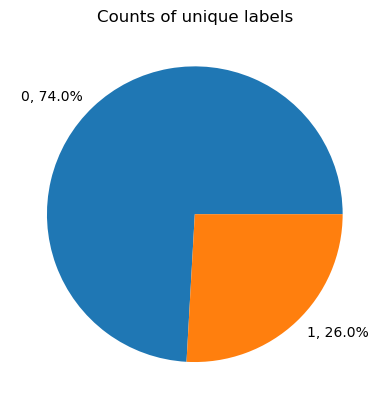

In [35]:
train_dataframe, test_dataframe, labels_array = read_datasets(train_path='train_agg.parquet',
                                                              test_path='test_agg.parquet',
                                                              labels_path='train_labels.csv')

In [36]:
train_dataframe, test_dataframe = encode_datasets(train=train_dataframe,
                                                  test=test_dataframe,
                                                  agg_cat_cols=cats,
                                                  prep_flag=PREPROCESS.xgb_lgb_prep)

Preprocessing for LGB / XGB


C:\Users\boomb\AppData\Local\Temp\ipykernel_3116\1586015362.py:105: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test.insert(loc=idx, column='D_64_last_-1', value=[0] * len(test))


CONFIG_XGB
Booster parameters:
eta: 0.04
gamma: 0
max_depth: 6
min_child_weight: 1
max_delta_step: 2
max_leaves: 127
objective: binary:logistic
scale_pos_weight: 3
disable_default_eval_metric: 1
tree_method: hist
.train() args:
Number of boosting rounds: 1500
Early stopping rounds: 1000
Verbose eval: 250
Stratified K-Fold number of splits: 5
END OF CONFIG
====== Fold number: 1
label counts in train
Count of 0: (272068 / 367130), percentage = 74.11%
Count of 1: (95062 / 367130), percentage = 25.89%
label counts in test(eval)
Count of 0: (68017 / 91783), percentage = 74.11%
Count of 1: (23766 / 91783), percentage = 25.89%
[0]	train-amex_metric:0.70709	valid-amex_metric:0.70018
[250]	train-amex_metric:0.81300	valid-amex_metric:0.78412
[500]	train-amex_metric:0.84229	valid-amex_metric:0.78869
[750]	train-amex_metric:0.86653	valid-amex_metric:0.78986
[999]	train-amex_metric:0.88869	valid-amex_metric:0.79060


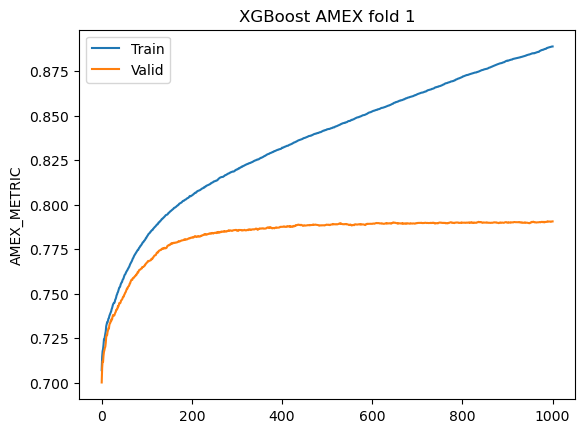

Fold model successfully trained. Predictions saved
fold 1 score: 0.7905785937308935
====== Fold number: 2
label counts in train
Count of 0: (272068 / 367130), percentage = 74.11%
Count of 1: (95062 / 367130), percentage = 25.89%
label counts in test(eval)
Count of 0: (68017 / 91783), percentage = 74.11%
Count of 1: (23766 / 91783), percentage = 25.89%
[0]	train-amex_metric:0.69770	valid-amex_metric:0.69199
[250]	train-amex_metric:0.81367	valid-amex_metric:0.78238
[500]	train-amex_metric:0.84135	valid-amex_metric:0.78612
[750]	train-amex_metric:0.86579	valid-amex_metric:0.78701
[1000]	train-amex_metric:0.88842	valid-amex_metric:0.78668


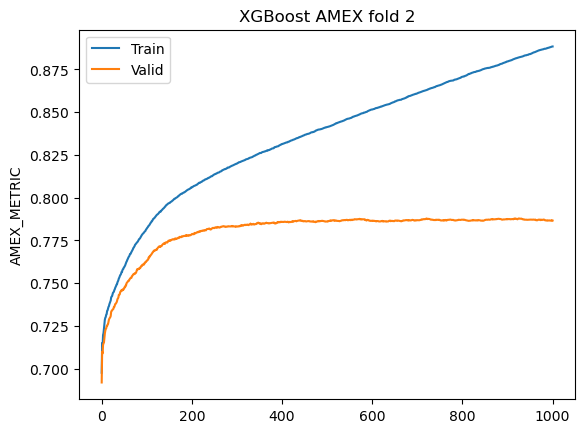

Fold model successfully trained. Predictions saved
fold 2 score: 0.7866787884227324
====== Fold number: 3
label counts in train
Count of 0: (272068 / 367130), percentage = 74.11%
Count of 1: (95062 / 367130), percentage = 25.89%
label counts in test(eval)
Count of 0: (68017 / 91783), percentage = 74.11%
Count of 1: (23766 / 91783), percentage = 25.89%
[0]	train-amex_metric:0.69668	valid-amex_metric:0.69585
[250]	train-amex_metric:0.81261	valid-amex_metric:0.78287
[500]	train-amex_metric:0.84004	valid-amex_metric:0.78707
[750]	train-amex_metric:0.86464	valid-amex_metric:0.78863
[999]	train-amex_metric:0.88679	valid-amex_metric:0.78941


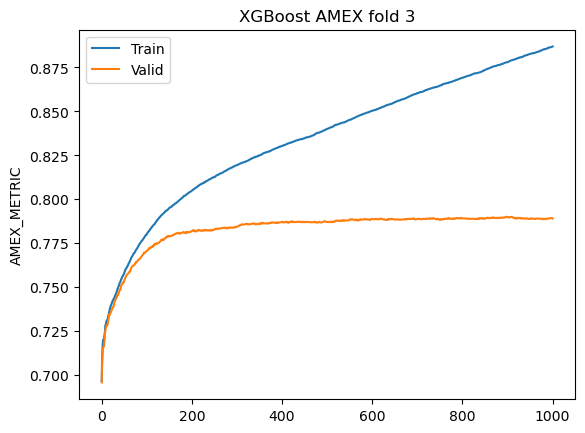

Fold model successfully trained. Predictions saved
fold 3 score: 0.7891330123776574
====== Fold number: 4
label counts in train
Count of 0: (272068 / 367131), percentage = 74.11%
Count of 1: (95063 / 367131), percentage = 25.89%
label counts in test(eval)
Count of 0: (68017 / 91782), percentage = 74.11%
Count of 1: (23765 / 91782), percentage = 25.89%
[0]	train-amex_metric:0.70131	valid-amex_metric:0.69786
[250]	train-amex_metric:0.81266	valid-amex_metric:0.78437
[500]	train-amex_metric:0.84087	valid-amex_metric:0.79051
[750]	train-amex_metric:0.86604	valid-amex_metric:0.79262
[999]	train-amex_metric:0.88766	valid-amex_metric:0.79293


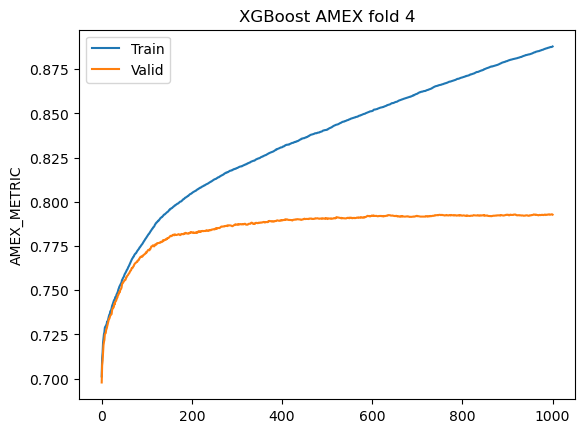

Fold model successfully trained. Predictions saved
fold 4 score: 0.7927446585496534
====== Fold number: 5
label counts in train
Count of 0: (272068 / 367131), percentage = 74.11%
Count of 1: (95063 / 367131), percentage = 25.89%
label counts in test(eval)
Count of 0: (68017 / 91782), percentage = 74.11%
Count of 1: (23765 / 91782), percentage = 25.89%
[0]	train-amex_metric:0.69711	valid-amex_metric:0.69387
[250]	train-amex_metric:0.81279	valid-amex_metric:0.78547
[500]	train-amex_metric:0.84069	valid-amex_metric:0.78922
[750]	train-amex_metric:0.86448	valid-amex_metric:0.79043
[1000]	train-amex_metric:0.88760	valid-amex_metric:0.78967


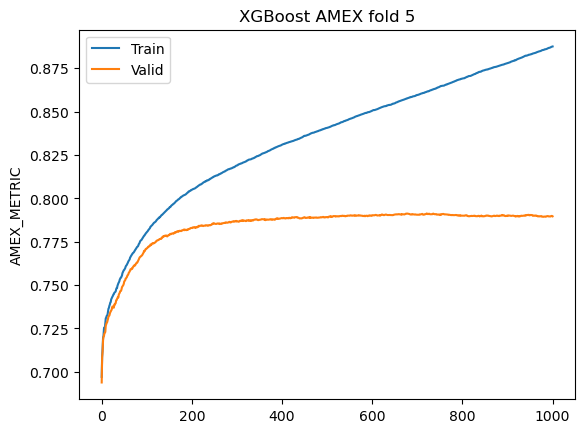

Fold model successfully trained. Predictions saved
fold 5 score: 0.7896716143585738
TOTAL out of folds score: 0.7898089452659189


In [37]:
output_xgb = train_and_predict_xgb(train_dataframe, test_dataframe, labels_array, config_xgb)

CONFIG_LGBM
Booster parameters:
boosting_type: dart
objective: binary
max_delta_step: 2
scale_pos_weight: 2.86
learning_rate: 0.04
num_leaves: 127
.train() args:
Number of boosting rounds: 1200
Early stopping rounds: 900
Verbose eval: 200
Stratified K-Fold number of splits: 5
END OF CONFIG
Fold number: 1
label counts in train
Count of 0: (272068 / 367130), percentage = 74.11%
Count of 1: (95062 / 367130), percentage = 25.89%
label counts in test(eval)
Count of 0: (68017 / 91783), percentage = 74.11%
Count of 1: (23766 / 91783), percentage = 25.89%
[LightGBM] [Info] Number of positive: 95062, number of negative: 272068
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.724593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 221186
[LightGBM] [Info] Number of data points in the train set: 367130, number of used features: 925
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258933 -> initscore=-1.05152

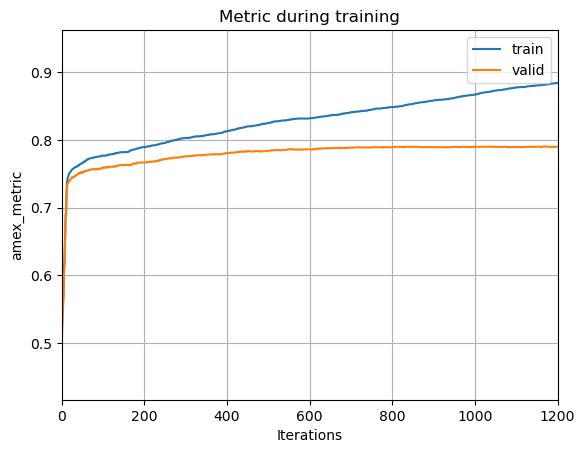

Fold model successfully trained. Predictions saved
fold 1 score: 0.7898334523732535
Fold number: 2
label counts in train
Count of 0: (272068 / 367130), percentage = 74.11%
Count of 1: (95062 / 367130), percentage = 25.89%
label counts in test(eval)
Count of 0: (68017 / 91783), percentage = 74.11%
Count of 1: (23766 / 91783), percentage = 25.89%
[LightGBM] [Info] Number of positive: 95062, number of negative: 272068
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.713270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 221179
[LightGBM] [Info] Number of data points in the train set: 367130, number of used features: 925
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258933 -> initscore=-1.051523
[LightGBM] [Info] Start training from score -1.051523
[200]	train's binary_logloss: 0.27199	train's amex_metric: 0.790047	valid's binary_logloss: 0.284895	valid's amex_metric: 0.765584
[400]	train's binary

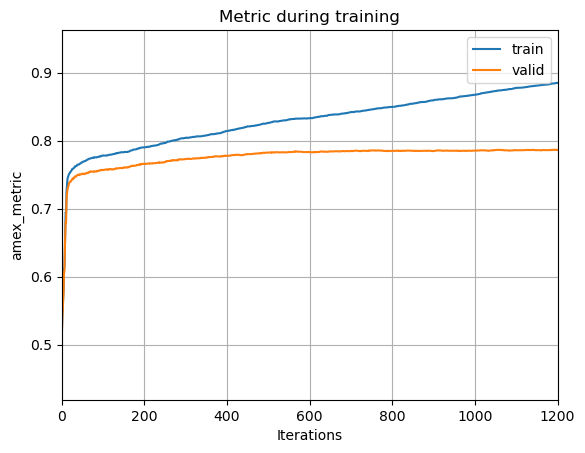

Fold model successfully trained. Predictions saved
fold 2 score: 0.7862556998411561
Fold number: 3
label counts in train
Count of 0: (272068 / 367130), percentage = 74.11%
Count of 1: (95062 / 367130), percentage = 25.89%
label counts in test(eval)
Count of 0: (68017 / 91783), percentage = 74.11%
Count of 1: (23766 / 91783), percentage = 25.89%
[LightGBM] [Info] Number of positive: 95062, number of negative: 272068
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.609181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 221175
[LightGBM] [Info] Number of data points in the train set: 367130, number of used features: 925
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258933 -> initscore=-1.051523
[LightGBM] [Info] Start training from score -1.051523
[200]	train's binary_logloss: 0.272467	train's amex_metric: 0.789466	valid's binary_logloss: 0.284108	valid's amex_metric: 0.768873
[400]	train's binar

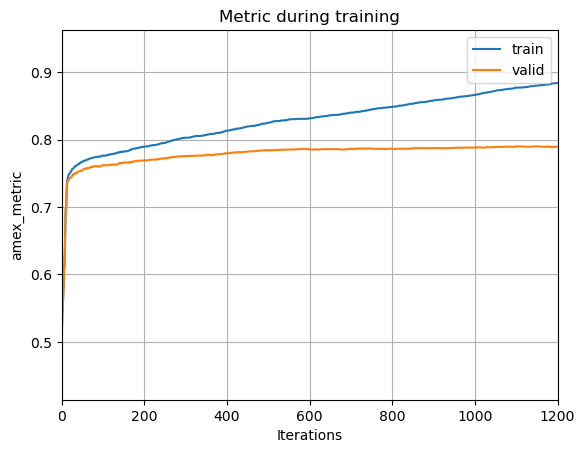

Fold model successfully trained. Predictions saved
fold 3 score: 0.7895723298235053
Fold number: 4
label counts in train
Count of 0: (272068 / 367131), percentage = 74.11%
Count of 1: (95063 / 367131), percentage = 25.89%
label counts in test(eval)
Count of 0: (68017 / 91782), percentage = 74.11%
Count of 1: (23765 / 91782), percentage = 25.89%
[LightGBM] [Info] Number of positive: 95063, number of negative: 272068
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.643903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 221195
[LightGBM] [Info] Number of data points in the train set: 367131, number of used features: 925
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258935 -> initscore=-1.051512
[LightGBM] [Info] Start training from score -1.051512
[200]	train's binary_logloss: 0.272811	train's amex_metric: 0.788739	valid's binary_logloss: 0.283311	valid's amex_metric: 0.770644
[400]	train's binar

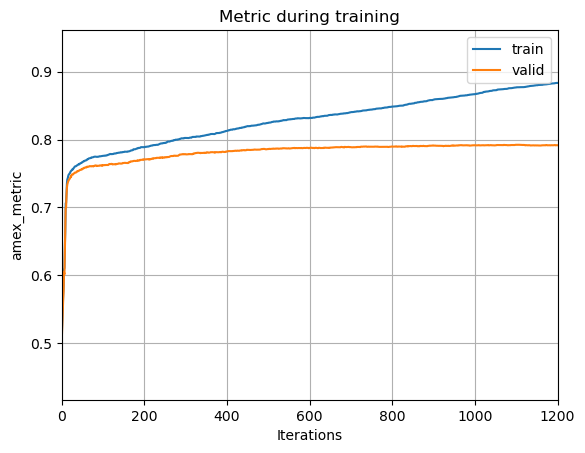

Fold model successfully trained. Predictions saved
fold 4 score: 0.7915989105450953
Fold number: 5
label counts in train
Count of 0: (272068 / 367131), percentage = 74.11%
Count of 1: (95063 / 367131), percentage = 25.89%
label counts in test(eval)
Count of 0: (68017 / 91782), percentage = 74.11%
Count of 1: (23765 / 91782), percentage = 25.89%
[LightGBM] [Info] Number of positive: 95063, number of negative: 272068
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.750951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 221169
[LightGBM] [Info] Number of data points in the train set: 367131, number of used features: 925
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258935 -> initscore=-1.051512
[LightGBM] [Info] Start training from score -1.051512
[200]	train's binary_logloss: 0.272611	train's amex_metric: 0.789017	valid's binary_logloss: 0.282503	valid's amex_metric: 0.770599
[400]	train's binar

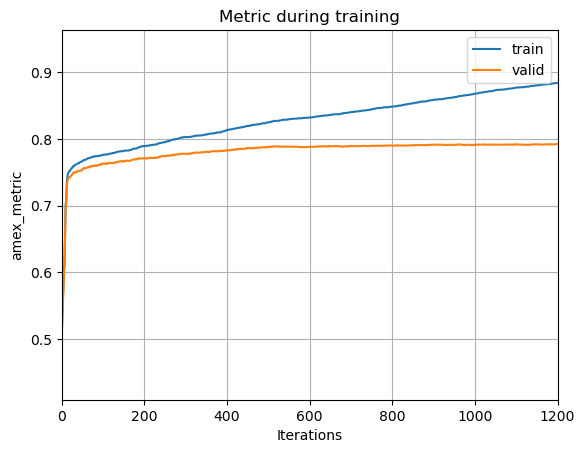

Fold model successfully trained. Predictions saved
fold 5 score: 0.7922724197234121
Total out of folds score: 0.7898545966541983


In [38]:
output_lgb = train_and_predict_lgbm(train_dataframe, test_dataframe, labels_array, config_lgb)

In [39]:
output_xgb.to_csv('C:/Users/boomb/Documents/kaggle_subs/xgb_scaled_sub.csv', index=False)
output_lgb.to_csv('C:/Users/boomb/Documents/kaggle_subs/lgb_scaled_dart_sub.csv', index=False)

In [40]:
config_lgb.save('C:/Users/boomb/Documents/kaggle_subs/lgb_scaled_sub_config.txt')
config_xgb.save('C:/Users/boomb/Documents/kaggle_subs/xgb_scaled_sub_config.txt')